# Install Required Libraries

In [ ]:
# Install required library for drawing
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Required Libraries

In [ ]:
# Import required libraries
import graphviz
import json
import re
from collections import deque

# Requirement 1

In [ ]:
class Preprocessor:

  # We will use '\' as our concatenation character according to Shunting yard algorithm
  operators_perecedence = { '*': 1, '+' : 1, '?': 1, '\\': 2, '|': 3}
  operators_str = '*+?\\|'
  matching_brackets = {']' : '[', ')' : '('}
  opened_brackets = ['(', '[']
  closed_brackets = [')', ']']

  no_conact_after = opened_brackets + ['-', '|']
  no_concat_before = closed_brackets + ['-'] + list(operators_perecedence.keys())

  @staticmethod
  def validate_expression(expression : str) -> bool:
    '''
    A function that is used to check if regex expression is valid or not

    Inputs:
    expression -> A string representing regex expression

    Output:
    A boolean representing whether the regex expression is valid or not
    '''
    try:
      pattern = re.compile(expression)
      return True
    except Exception as e:
      return False

  @staticmethod
  def preprocess_regex(regex : str) -> str:
    '''
    This function parses regex expression using Shunting Yard parsing algorithm. It returns a string
    representing the parsed regex expression in postfix notation. Our approach uses "\\" character for concatenation.

    Inputs:
    regex -> representing regex expression

    Outputs:
    A string representing parsed postfix regular expression
    '''

    # Data structures required for Shunting Yard algorithms
    operator_stack = []
    output_postfix = []

    # Stack to keep of ranges and accept characters as regular characters in [ ]
    ranges_stack = []

    # The new regex expression after injecting '\' as concatenation operator
    new_regex = []
    for i in range(len(regex)):
      new_regex.append(regex[i])

      # This is to keep track of square brackets stack
      if regex[i] == '[':
        ranges_stack.append('[')
      elif regex[i] == ']':
        ranges_stack.pop()

      if len(ranges_stack) == 0 and i + 1 < len(regex) and regex[i] not in Preprocessor.no_conact_after and regex[i+1] not in Preprocessor.no_concat_before:
        new_regex.append('\\')

    ranges_stack = []
    for char in new_regex:
      if char not in Preprocessor.operators_perecedence and char != ')' and char != '(' or len(ranges_stack) > 0:
        if char == '[':
          ranges_stack.append('[')
        elif char == ']':
          ranges_stack.pop()
        output_postfix.append(char)
      else:
        if char == '(':
          operator_stack.append(char)
        elif char == ')':
          while True:
            top = operator_stack.pop()
            if top == '(':
              break
            output_postfix.append(top)
        elif char in Preprocessor.operators_perecedence:
          while len(operator_stack) > 0 and operator_stack[-1] in Preprocessor.operators_perecedence:
            top = operator_stack[-1]
            if Preprocessor.operators_perecedence[top] <= Preprocessor.operators_perecedence[char]:
              operator_stack.pop()
              output_postfix.append(top)
            else:
              break
          operator_stack.append(char)
        else:
          output_postfix.append(char)

    # Loop over the operator stack and append the rest of the operators to the output postfix
    while len(operator_stack) > 0:
      output_postfix.append(operator_stack.pop())

    return ''.join(output_postfix)

In [ ]:
class NFA:
  def __init__(self):
    self.graph = graphviz.Digraph('NFA', format='png')
    self.graph.attr(rankdir='LR', size='600, 800')
    self.graph.attr('node', shape='circle')

    self.current_state = 1
    self.start_state = 'S0'

    self.terminal_state = None
    self.transition_table : dict(str, list(tuple(str, str))) = {'': [] , self.start_state : []}
    self.graph.node('', shape='none')
    self.connect_edge('', self.start_state, 'Start')
    self.nfa_stack = []

  def add_state(self, is_terminal: bool = False) -> str:
    state_name = f'S{self.current_state}'
    self.graph.node(state_name, state_name, shape= 'circle' if not is_terminal else 'doublecircle')
    self.transition_table[state_name] = []
    self.current_state += 1

    return state_name

  def connect_edge(self, start_state_name : str, end_state_name: str, input_label: str) -> None:
    if start_state_name not in self.transition_table or end_state_name not in self.transition_table:
      if start_state_name not in self.transition_table:
        print(f'No state created with the name {start_state_name}')
      if end_state_name not in self.transition_table:
        print(f'No state created with the name {end_state_name}')
      return
    self.graph.edge(start_state_name, end_state_name, label=input_label)
    self.transition_table[start_state_name].append((input_label, end_state_name))

  def display_nfa(self):
    self.graph.render('NFA', view=True)

  def draw_nfa(self, postfix_notation):
    self.nfa_stack = []
    i = 0
    while i < len(postfix_notation):
      added_nfa = []
      if postfix_notation[i] == '[':

        while postfix_notation[i] != ']' and i < len(postfix_notation):
          added_nfa.append(postfix_notation[i])
          i += 1

      if i < len(postfix_notation):
        added_nfa.append(postfix_notation[i])

      input_token = ''.join(added_nfa)
      if input_token not in Preprocessor.operators_str:
        start_state = self.add_state()
        end_state = self.add_state()
        self.connect_edge(start_state, end_state, input_token)
        nfa_unit = (start_state, end_state)
        self.nfa_stack.append(nfa_unit)
      else:
        if input_token == '|':
          first_unit = self.nfa_stack.pop()
          second_unit = self.nfa_stack.pop()

          start_state = self.add_state()
          mid_state = self.add_state()
          end_state = self.add_state()

          self.connect_edge(start_state, mid_state, 'ε')
          self.connect_edge(mid_state, second_unit[0], 'ε')
          self.connect_edge(mid_state, first_unit[0], 'ε')
          self.connect_edge(second_unit[1], end_state, 'ε')
          self.connect_edge(first_unit[1], end_state, 'ε')

          nfa_unit = (start_state, end_state)
          self.nfa_stack.append(nfa_unit)
        elif input_token == '*':
          start_state, old_end_state = self.nfa_stack.pop()

          new_end_state = self.add_state()
          self.connect_edge(old_end_state, new_end_state, 'ε')
          self.connect_edge(start_state, new_end_state, 'ε')
          self.connect_edge(old_end_state, start_state, 'ε')

          self.nfa_stack.append((start_state, new_end_state))

        elif input_token == '+':
          start_state, old_end_state = self.nfa_stack.pop()

          new_end_state = self.add_state()
          self.connect_edge(old_end_state, new_end_state, 'ε')
          self.connect_edge(old_end_state, start_state, 'ε')

          self.nfa_stack.append((start_state, new_end_state))
        elif input_token == '\\':
          first_unit = self.nfa_stack.pop()
          second_unit = self.nfa_stack.pop()

          new_start = second_unit[0]
          new_end = first_unit[1]
          self.connect_edge(second_unit[1], first_unit[0], 'ε')
          self.nfa_stack.append((new_start, new_end))
        elif input_token == '?':
          start_state, old_end_state = self.nfa_stack.pop()
          new_end_state = self.add_state()

          self.connect_edge(old_end_state, new_end_state, 'ε')
          self.connect_edge(start_state, new_end_state, 'ε')
          self.nfa_stack.append((start_state, new_end_state))

      i += 1
    if len(self.nfa_stack) == 0:
      self.terminal_state = self.start_state
      self.graph.node(self.start_state, shape='doublecircle')
    else:
      start_state, end_state = self.nfa_stack[-1]
      self.connect_edge(self.start_state, start_state, 'ε')
      self.terminal_state = end_state
      self.graph.node(end_state, shape="doublecircle")

    self.display_nfa()

  def merge_states(self, state : str, traversed_states = []):
    if state not in traversed_states:
      traversed_states.append(state)
    for input, connected_state in self.transition_table[state]:
      if input == 'ε':
        self.merge_states(connected_state, traversed_states)

  def export_nfa_json(self) -> None:
    json_dict = {"startingState" : f"{self.start_state}"}
    for state_name in self.transition_table:
      if state_name == '':
        continue
      json_dict[state_name] = {}
      connected_states = self.transition_table[state_name]

      json_dict[state_name]["isTerminatingState"] = str(self.terminal_state == state_name)
      for input, connected_state in connected_states:
        input = input if input != 'ε' else 'epsilon'
        if input not in json_dict[state_name]:
          json_dict[state_name][input] = [connected_state]
        else:
          json_dict[state_name][input].append(connected_state)

    with open("nfa.json", "w", encoding='utf8') as outfile:
      json.dump(json_dict, outfile, indent=4)

# Requirement 2

In [ ]:
class DFA:
  def __init__(self, nfa_object : NFA):

    # Standard DFA graph
    self.graph = graphviz.Digraph('DFA', format='png')
    self.graph.attr(rankdir='LR', size='600, 800')
    self.graph.attr('node', shape='circle')
    self.graph.node('', shape='none')
    self.is_dfa_built = False
    self.is_dfa_drawn = False

    # Minimized DFA graph
    self.minimized_graph = graphviz.Digraph('Minimized_DFA', format='png')
    self.minimized_graph.attr(rankdir='LR', size='600, 800')
    self.minimized_graph.attr('node', shape='circle')
    self.minimized_graph.node('', shape='none')
    self.is_minimized_dfa_built = False
    self.is_minimized_dfa_drawn = False

    # Current State to be added
    self.start_state = self.current_state =  0

    # Used to map states sets to names
    self.state_names : dict(frozenset, str) = {}

    # Used to store the transition of the states
    self.transition_table : dict(frozenset, (list(tuple(str, str)), bool)) = {}
    self.dfa_state_names_transition_table : dict(str, (list(tuple(str, str)), bool)) = {}
    self.minimized_dfa_transition_table : dict(str, (list(tuple(str, str)), bool)) = {}

    # The NFA object from which we will build our DFA
    self.nfa = nfa_object

  def add_state(self, states: frozenset, is_terminal = False) -> bool:
    '''
    A function that adds a set of merged states to the transition table of the DFA.

    Inputs:
    states: A frozenset of states collected together.
    is_terminal: Determines whether this set of states is terminal or not

    Outputs:
    Returns True if the states are successfully added to the transition table and returns False if the states are already added or otherwise.
    '''
    try:
      if states in self.transition_table:
        print('States are already added')
        return False

      state_name = f'S{self.current_state}'
      self.transition_table[states] = ([], is_terminal)
      self.state_names[states] = state_name
      self.current_state += 1

      return True
    except Exception as e:
      print(repr(e))
      return False

  def build_dfa_from_nfa(self) -> bool:
    '''
    A function that builds the DFA transition table based on the NFA object.

    Outputs:
    Returns True if the DFA is built successfully and returns False otherwise
    '''

    def build_dfa_state_names_transition_table():
      '''
      A function that builds a new transition table with keys as the states names instead of being merged states collection.
      '''
      for key in self.transition_table:
        self.dfa_state_names_transition_table[self.state_names[key]] = self.transition_table[key]

    def build_initial_state():
      '''
      A function that builds DFA inital state using the start state of the NFA object.

      Outputs:
      Returns a set of merged states using epsilon closure algorithm. The returned set represents the initial state of the DFA
      '''
      initial_state = []
      self.nfa.merge_states(self.nfa.start_state, initial_state)
      return initial_state

    try:
      # if the DFA is has been already constructed, we return False
      if self.is_dfa_built:
        return True

      # Get the initial state of the DFA
      initial_state = frozenset(build_initial_state())

      # Add the initial state to the transition table
      self.add_state(initial_state, self.nfa.terminal_state in initial_state)

      # The DFA states queue which we will use to explore the paths of the DFA states
      states_queue = deque([initial_state])

      while len(states_queue) > 0:
        # Pop the current state of the from the queue
        states = states_queue.popleft()

        # A dictionary that stores the destination sets of states along with the input for the current state
        input_paths : dict(str, set) = {}

        # We loop over our set of states to explore the paths
        for state in states:
          # We loop over the connected states of the current state. We only check the states that are not connected to our state with epsilon
          for input, connected_state in self.nfa.transition_table[state]:
            if input != 'ε':
              merged_states = []
              # if the input path is not in our dictionary, we add it
              if input not in input_paths:
                input_paths[input] = set()
              # We add the destination states to our corresponding input in the input paths dictionary
              self.nfa.merge_states(connected_state, merged_states)
              input_paths[input] = input_paths[input].union(set(merged_states))

        # We loop on the paths of our inputs for the current state to populate the transition table of the DFA
        for input, dest_states in input_paths.items():
          dest_states_frozen = frozenset(dest_states)
          # If the destination set of states are new and not added before. We add the set and append it to our DFA states queue for exploration in the next iteration
          if dest_states_frozen not in self.transition_table:
            self.add_state(dest_states_frozen, self.nfa.terminal_state in dest_states_frozen)
            states_queue.append(dest_states_frozen)

          # We add the destination set of states to the connected states of our transition table
          dest_state_name = self.state_names[dest_states_frozen]
          self.transition_table[states][0].append((input, dest_state_name))

      # Create a transition table with stte names as the keys instead of merged states collections
      build_dfa_state_names_transition_table()

      # Mark the DFA as built
      self.is_dfa_built = True

      return True

    except Exception as e:
      print(repr(e))
      return False

  def draw_dfa(self) -> bool:
    '''
    A function that is used to render DFA graph and displays output DFA graoh image.

    Output:
    Returns True if the graph is successfully rendered and displayed. Otherwise, return False
    '''
    def draw_node(name: str, is_terminal : bool) -> None:
      '''
      A function that draws a node in the DFA graph.

      Inputs:
      name -> A string representing the name label of the node.
      is_terminal -> A boolean to determine whether the node is terminal or not.
      '''
      self.graph.node(name, name, shape= 'circle' if not is_terminal else 'doublecircle')

    def connect_edge(start_state_name : str, end_state_name: str, input_label: str) -> None:
      '''
      A function that connect edges between the nodes of the DFA graph

      Inputs:
      start_state_name -> A string representing the name of the start state
      end_state_name -> A string representing the name of the end state
      input_label -> The label of the edge that connects the two nodes

      '''
      self.graph.edge(start_state_name, end_state_name, label=input_label)

    try:
      # If we have not built the DFA yet, we build it
      if not self.is_dfa_built:
        result = self.build_dfa_from_nfa()
        if not result:
          return False

      # If the graph is already ready, we just render it
      if self.is_dfa_drawn:
        self.graph.render(view=True)
        return True

      # We start by drawing all the nodes
      for state_name in self.dfa_state_names_transition_table:
        draw_node(state_name, self.dfa_state_names_transition_table[state_name][1])

      # We connect a start edge to our start state
      connect_edge('', 'S0', 'Start')

      for state_name in self.dfa_state_names_transition_table:
        for connected_state_info in self.dfa_state_names_transition_table[state_name][0]:
          input, connected_state = connected_state_info
          connect_edge(state_name, connected_state, input)

      # Mark graph as ready for display
      self.is_dfa_drawn = True

      # Render DFA graph
      self.graph.render(view=True)

      return True

    except Exception as e:
      print(repr(e))
      return False

  def draw_minimized_dfa(self) -> bool:
    def get_state_names_transition_table(state_sets) -> any:
      '''
      A function that gets the paths of each state according to the passed merged sets.

      Inputs:
      state_sets -> A dictionary with initial merged sets of states. The passed sets are created according to DFA minimization algorithm.

      Outputs:
      Returns a new transition table where each value represents the paths and the destination sets of states for the corresponding state.
      '''
      transition_table = {}
      for state_name in self.dfa_state_names_transition_table:
        new_dict = {}
        for input, connected_state in self.dfa_state_names_transition_table[state_name][0]:
          new_dict[input] = state_sets[connected_state]
        transition_table[state_name] = new_dict

      return transition_table

    def get_states_sets(sets_map) -> any:
      '''
      A function that returns a map of states. The value represents the set of states that each ste belong to during DFA minimization.

      Inputs:
      sets_map -> A dictionary with the merged state name as the key and the value is all merged states using DFA minimization.

      Outputs:
      Returns a map of states. The value represents the set of states that each ste belong to during DFA minimization.
      '''
      state_sets = {}
      for key in sets_map:
        for state in sets_map[key]:
          state_sets[state] = key
      return state_sets

    def get_is_terminal() -> any:
      '''
      Returns a map representing whether a state is terminal or not
      '''
      is_terminal_set = {}
      for states in self.transition_table:
        is_terminal_set[self.state_names[states]] = self.transition_table[states][1]
      return is_terminal_set

    def build_minimized_dfa() -> bool:
      '''
      A function that retruns True if the DFA is minmized successfully and returns False otherwise.
      '''
      try:
        # If we have not built the DFA yet, we build it
        if not self.is_dfa_built:
          self.build_dfa_from_nfa()

        # We start minimization algorithm by splitting our terminal and non-terminal sets
        initial_sets = {False: [], True: []}

        # We get the terminal info of our states
        is_terminal_set = get_is_terminal()

        for states in self.transition_table:
          state_name = self.state_names[states]
          initial_sets[is_terminal_set[state_name]].append(state_name)

        # We set our initial sets to our current sets
        current_sets = initial_sets

        #------------------------------ Start of minimization algorithm --------------------------------
        while True:
          # We get the set that each state belongs to
          states_sets = get_states_sets(current_sets)

          # We get the paths of each state
          states_paths = get_state_names_transition_table(states_sets)

          # This is our new sets after merging according to paths
          new_sets = {}

          # This is our next current sets
          next_sets = {}

          # We loop over the paths of our states and create a dictionary with the paths and terminal info as key
          # If two states have the same key, we merge them together
          for current_set in current_sets:
            for current_state in current_sets[current_set]:
              state_path = states_paths[current_state]
              new_set_key = (frozenset(state_path.items()), is_terminal_set[current_state])
              if new_set_key not in new_sets:
                new_sets[new_set_key] = [current_state]
              else:
                new_sets[new_set_key].append(current_state)

          # We create a new dictionary with a representative of our merged states as the key
          for key in new_sets:
            merged_states = new_sets[key]
            next_sets[merged_states[0]] = merged_states

          # If we end up with same number of merged states, then we are done
          prev_len = len(current_sets)
          if len(next_sets) == prev_len:
            break

          current_sets = next_sets
        #------------------------------ End of minmization algorithm --------------------------------

        # We create a map where each state is mapped to the name of its representative
        renamed_states = {}
        for state in current_sets:
          for merged_state in current_sets[state]:
            renamed_states[merged_state] = state if state is not False and state is not True else initial_sets[state][0]

        # We start building our minimized DFA transition table based on the above information
        for state in self.dfa_state_names_transition_table:
          state_name = renamed_states[state]
          if state_name not in self.minimized_dfa_transition_table:
            old_paths, is_terminal = self.dfa_state_names_transition_table[state_name]
            new_paths = []
            for path in old_paths:
              input, old_name = path
              new_name = renamed_states[old_name]
              new_paths.append((input, new_name))

            self.minimized_dfa_transition_table[state_name] = (new_paths, is_terminal)

        return True
      except Exception as e:
        print(repr(e))
        return False


    def draw_node(name: str, is_terminal : bool) -> None:
      '''
      A function that draws a node in the minimized DFA graph.

      Inputs:
      name -> A string representing the name label of the node.
      is_terminal -> A boolean to determine whether the node is terminal or not.
      '''
      self.minimized_graph.node(name, name, shape= 'circle' if not is_terminal else 'doublecircle')

    def connect_edge(start_state_name : str, end_state_name: str, input_label: str) -> None:
      '''
      A function that connect edges between the nodes of the minimized DFA graph

      Inputs:
      start_state_name -> A string representing the name of the start state
      end_state_name -> A string representing the name of the end state
      input_label -> The label of the edge that connects the two nodes

      '''
      self.minimized_graph.edge(start_state_name, end_state_name, label=input_label)

    try:
      # If we have already drawn the minimized DFA, we display it
      if self.is_minimized_dfa_drawn:
        self.minimized_graph.render(view=True)
        return True

      # If the DFA is not built, we build it
      if not self.is_dfa_built:
        self.build_dfa_from_nfa()

      # If the DFA is not minimized already, we minimize it
      if not self.is_minimized_dfa_built:
        result = build_minimized_dfa()
        if not result:
          raise Exception('Error during minimization of DFA')


      # We start by drawing all the nodes
      for state_name in self.minimized_dfa_transition_table:
        draw_node(state_name, self.minimized_dfa_transition_table[state_name][1])

      # We connect a start edge to our start state
      connect_edge('', f'S{self.start_state}', 'Start')

      for state_name in self.minimized_dfa_transition_table:
        for connected_state_info in self.minimized_dfa_transition_table[state_name][0]:
          input, connected_state = connected_state_info
          connect_edge(state_name, connected_state, input)

      # Mark the minimized DFA as drawn
      self.is_minimized_dfa_drawn = True

      # Render our minimized DFA
      self.minimized_graph.render(view=True)

      return True
    except Exception as e:
      print(repr(e))
      return False


  def export_dfa_json(self) -> None:
    json_dict = {"startingState" : f"S{self.start_state}"}
    for state_name in self.dfa_state_names_transition_table:
      json_dict[state_name] = {}
      connected_states, is_terminal = self.dfa_state_names_transition_table[state_name]

      json_dict[state_name]["isTerminatingState"] = str(is_terminal)
      for input, connected_state in connected_states:
        json_dict[state_name][input] = connected_state

    with open("dfa.json", "w") as outfile:
      json.dump(json_dict, outfile, indent=4)

  def export_minimized_dfa_json(self) -> None:
    json_dict = {"startingState" : f"S{self.start_state}"}
    for state_name in self.minimized_dfa_transition_table:
      json_dict[state_name] = {}
      connected_states, is_terminal = self.minimized_dfa_transition_table[state_name]

      json_dict[state_name]["isTerminatingState"] = str(is_terminal)
      for input, connected_state in connected_states:
        json_dict[state_name][input] = connected_state

    with open("minimized_dfa.json", "w") as outfile:
      json.dump(json_dict, outfile, indent=4, ensure_ascii=False)



In [ ]:
expression = input()
if not Preprocessor.validate_expression(expression):
  print("Non valid regex expression")
else:
  modified_regex = Preprocessor.preprocess_regex(expression)
  nfa = NFA()
  nfa.draw_nfa(modified_regex)

  dfa = DFA(nfa)
  dfa.draw_minimized_dfa()
  dfa.draw_dfa()

  nfa.export_nfa_json()
  dfa.export_dfa_json()
  dfa.export_minimized_dfa_json()

a[a-z]b+


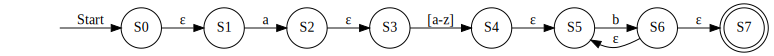

In [ ]:
nfa.graph

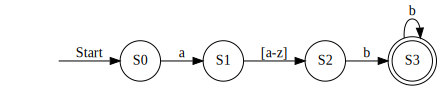

In [ ]:
dfa.graph

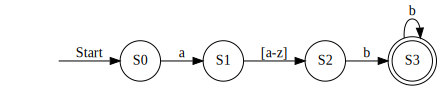

In [ ]:
dfa.minimized_graph

In [ ]:
dfa.export_dfa_json()

In [ ]:
dfa.export_minimized_dfa_json()

In [ ]:
nfa.export_nfa_json()